# Aim

1. To fit catagorical data of a logistic form by using gradient descent and exploring the effects of noise and number of data points on the goodness of fit.

2. To study the effect of regularization on the fitting capability as m increases.

# Generating Data

We generate data with the folowing function

$$Y = \begin{cases}
  1 & \text{if } \frac{1}{1 + \exp(-X\cdot\beta) > 0.5} \\
  0 & \text{otherwise}
\end{cases}$$

1. X is sampled uniformly in [-1, 1]
2. $X_{i,0}$ is set to 1 for all $i$
3. $\beta[i]$ is sampled uniformly in [-1, 1]
4. $\beta[i]$ is scaled by $\min(\beta[i:])/2$ to make sure all steps are within [-0.5, 0.5]
5. Noise of the binomial form is added with a flip parameter of $\theta$

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def make_data(theta, n, m):
    X = (np.random.random((n, m+1)) * 2 - 1)
    X[:, 0] = 1
    b = (np.random.random((m+1, 1)) * 2 - 1)
    b[0] *= np.min(b[1:])/2
    
    yprev = (1/(1 + np.exp(-X@b))) > 0.5
    noise = np.random.random((n, 1)) < theta
    return X, (yprev ^ noise)*1., b

# Model Functions

We define the following functions

## `predict`

This is the function given X and $\beta$ returns 

$$\frac{1}{1+\exp(-X\cdot\beta)}$$

This is the prediction of our model.

## `gradient`

This is the gradient we use to optimize the cost.
It is defined as

$$-X^T \cdot (Y-\text{predict}(X, \beta))$$

## `cost`

This is the cost we want to optimize.

It is defined as

$$-\frac{\sum_{i=0}^n\left(y_i\log(p_i) + (1-y_i)(1-\log(p_i))\right)}{n}$$

Or, in matrix notation,

$$-\frac{Y^T\cdot \log(P) + (1-y^T)\cdot\log(1-P)}{n}$$

In [3]:
def predict(X, beta):
    return 1 /(1+np.exp(-X@beta))

def gradient(X, y, beta_guess):
    return - X.T@(y - predict(X, beta_guess))/y.size

def cost(X, y, beta_guess):
    p = predict(X, beta_guess) * 0.99998 + 0.00001
    return -(y.T @ np.log(p) + (1-y.T)@np.log(1-p))/y.size

# Gradient Descent

Finally, we can define the gradient descent as usual.

In [4]:
def gradient_descent(X, y, k, tau, alpha=0.1, gradient=gradient, cost=cost):
    beta_guess = np.random.random((X.shape[1], 1))
    costs = np.zeros(k+1)
    costs[0] = cost(X, y, beta_guess)
    epochs_run = k
    for i in range(1, k):
        beta_guess = beta_guess - gradient(X, y, beta_guess) * alpha
        costs[i] = cost(X, y, beta_guess)
        if np.abs(costs[i+1] - costs[i]) < tau:
            epochs_run = i
            break
    return beta_guess, costs, epochs_run

# Observations

In [5]:
X, Y, b = make_data(0.05, 200, 1)
beta_guess, costs, epochs_run = gradient_descent(X, Y, 75000, 1e-4)

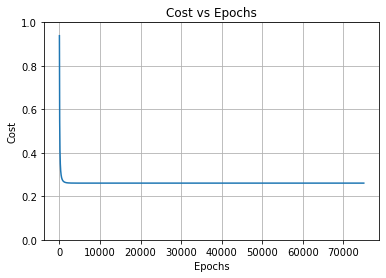

In [6]:
plt.plot(costs[:epochs_run])
plt.ylim([0, 1]);
plt.grid()
plt.ylabel("Cost")
plt.xlabel("Epochs")
plt.title("Cost vs Epochs");

Text(0.5, 1.0, 'Y vs X')

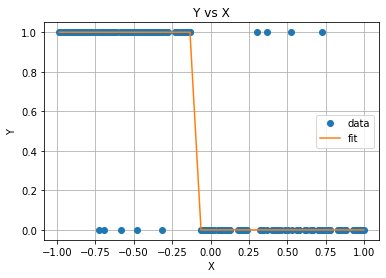

In [7]:
order = np.argsort(X[:, 1])
plt.plot(X[:, 1], Y, "o", label="data")
plt.plot(X[:, 1][order], (predict(X, beta_guess)>0.5)[order], label="fit")
plt.grid()
plt.legend()
plt.ylabel("Y")
plt.xlabel("X")
plt.title("Y vs X")

As we can see, the model is able to fit the data very well, and the cost falls pretty fast.

Hence, we verify that our code is working as intended

# Goodness of fit vs Data Parameters

We intend to measure the goodness of fit as a function of the data parameters $\theta$ and $n$. For this, we scan over a range of values for one parameter and keep the other fixed. We then measure the goodness of fit by 2 methods

1. Final Cost - The cost after 10000 steps.This is non zero if convergence does not occur
2. Prediction rate - Data is split into test and train with a ratio of 3:7. Model is trained over train set, and accuracy is measured against the test data

## Noise parameter $\theta$

In [8]:
def scan_theta(average_over, n, thetas=None):
    if thetas is None:
        thetas = np.arange(0, 0.21, 0.01)
    costs = np.zeros(thetas.size, dtype="float64")
    prediction_rate = np.zeros(thetas.size, dtype="float64")
    for i in range(len(thetas)):
        for j in range(average_over):
            X, Y, bstar = make_data(thetas[i], n, 5)
            b, tcosts, _ = gradient_descent(X[:(n*7)//10, :], Y[:(n*7)//10, :], 1000, 1e-7, 0.1)
            costs[i] += tcosts[-1]
            prediction_rate[i] += 1 - np.sum(np.abs(predict(X[(n*7)//10:, :], b) - Y[(n*7)//10:, :]))/((3*n)//10)
        costs[i] /= average_over
        prediction_rate[i] /= average_over
    return thetas, costs, prediction_rate

In [9]:
ms, costs, prediction_rate = scan_theta(5, 200, np.arange(0, 1.01, 0.05))

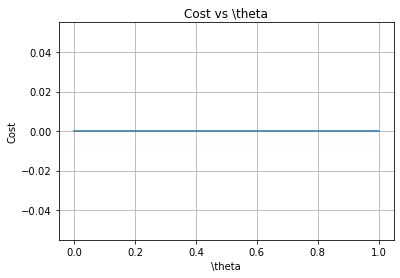

In [10]:
plt.plot(ms, costs)
plt.grid()
plt.ylabel("Cost")
plt.xlabel("\\theta")
plt.title("Cost vs \\theta");

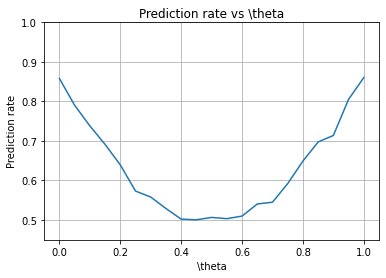

In [11]:
plt.plot(ms, prediction_rate)
plt.ylim(.45, 1)
plt.grid()
plt.ylabel("Prediction rate")
plt.xlabel("\\theta")
plt.title("Prediction rate vs \\theta");

As we can see, the cost is always zero, hence it is always converged.
Further, the prediction rate first falls to the theoretical minimum of 0.5, which is as good as a random guess. Then it again starts rising as our noise is so high, it is as good as a noise of $1-\theta$ for the reverse fit.

## Number of data points $n$

In [12]:
def scan_ns(average_over, theta, ns=None):
    if ns is None:
        ns = np.arange(10, 400, 18)
    costs = np.zeros(ns.size, dtype="float64")
    prediction_rate = np.zeros(ns.size, dtype="float64")
    for i in range(len(ns)):
        for j in range(average_over):
            X, Y, bstar = make_data(theta, ns[i], 5)
            b, tcosts, _ = gradient_descent(X[:(ns[i]*7)//10, :], Y[:(ns[i]*7)//10, :], 1000, 1e-7, 0.1)
            costs[i] += tcosts[-1]
            prediction_rate[i] += 1 - np.sum(np.abs(predict(X[(ns[i]*7)//10:, :], b) - Y[(ns[i]*7)//10:, :]))/((3*ns[i])//10)
        costs[i] /= average_over
        prediction_rate[i] /= average_over
    return ns, costs, prediction_rate

In [13]:
ns, costs, prediction_rate = scan_ns(10, 0.1)

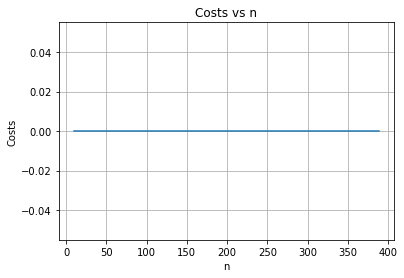

In [14]:
plt.plot(ns, costs)
plt.grid()
plt.ylabel("Costs")
plt.xlabel("n")
plt.title("Costs vs n");

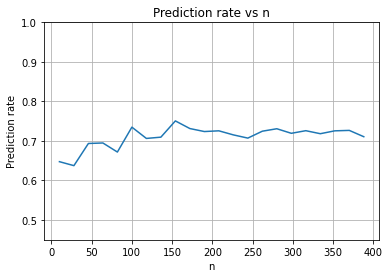

In [15]:
plt.plot(ns, prediction_rate)
plt.ylim(0.45, 1)
plt.grid()
plt.ylabel("Prediction rate")
plt.xlabel("n")
plt.title("Prediction rate vs n");

As we can see, the model always converges, and the prediction rate does not vary appreciably with an increase in data points. This may be because as the number of points increas, the number of noisy points also increase proportionally, and the noise has equal effect, as it is of the binomial form.

# Regularization
Now, we can see the effect of regularization when we increase the number of features.

## Ridge Regularization / $L_2$ Norm
We first define a new cost and gradient function corresponding to the $L_2$ Regularization

$$\text{Cost}_{L_2} = \text{Cost} + \lambda||\beta||_2$$
$$\text{Gradient}_{L_2} = \text{Gradient} + \lambda I' \beta$$

In [16]:
def cost_l2(X, Y, beta, lamda):
    return cost(X, Y, beta) + lamda*np.linalg.norm(beta[1:])

def gradient_l2(X, Y, beta, lamda):
    reg = lamda*beta
    reg[0] = 0
    return gradient(X, Y, beta) + lamda*reg

In [17]:
def scan_ms(average_over, lamda):
    n = 100
    theta = 0.1
    cl2 = lambda X,Y,beta: cost_l2(X, Y, beta, lamda)
    g2 = lambda X,Y,beta: gradient_l2(X, Y, beta, lamda)
    ms = np.arange(10, 200, 8)
    costs = np.zeros(ms.size, dtype="float64")
    prediction_rate = np.zeros(ms.size, dtype="float64")
    for i in range(len(ms)):
        for j in range(average_over):
            X, Y, bstar = make_data(theta, n, ms[i])
            b, tcosts, _ = gradient_descent (X[:(n*7)//10, :], Y[:(n*7)//10, :], 1000, 1e-7, 0.2, g2, cl2)
            costs[i] += tcosts[-1]
            prediction_rate[i] += 1 - np.sum(np.abs(predict(X[(n*7)//10:, :], b) - Y[(n*7)//10:, :]))/((3*n)//10)
        costs[i] /= average_over
        prediction_rate[i] /= average_over
    return ms, costs, prediction_rate

In [18]:
ms_001, costs_001, prediction_rate_001 = scan_ms(5, 0.01)
ms_01, costs_01, prediction_rate_01 = scan_ms(2, 0.1)
ms_1, costs_1, prediction_rate_1 = scan_ms(5, 0.1)
ms_0, costs_0, prediction_rate_0 = scan_ms(5, 0)

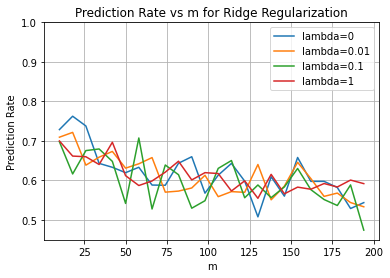

In [19]:
plt.plot(ms_0, prediction_rate_0, label="lambda=0")
plt.plot(ms_001, prediction_rate_001, label="lambda=0.01")
plt.plot(ms_01, prediction_rate_01, label="lambda=0.1")
plt.plot(ms_1, prediction_rate_1, label="lambda=1")
plt.ylim(0.45, 1)
plt.xlabel("m")
plt.ylabel("Prediction Rate")
plt.grid()
plt.title("Prediction Rate vs m for Ridge Regularization")
plt.legend();

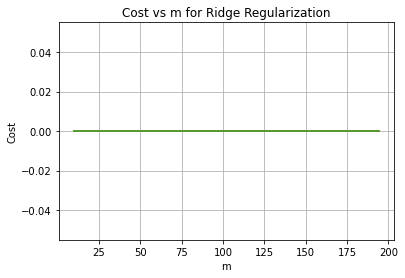

In [20]:
plt.plot(ms_001, costs_001)
plt.plot(ms_01, costs_01)
plt.plot(ms_1, costs_1)
plt.xlabel("m")
plt.ylabel("Cost")
plt.grid()
plt.title("Cost vs m for Ridge Regularization");

Again, we see that the model always converges. However, we see that using Ridge Regularization doesn't play such a big role for any $m$, as on an average, all beta values have nearly same size and are equally important. This may not be the case in real data, where regularization is able to ignore these "extra" parameters which are only weakly correlated with the data.

## Lasso Regularization / $L_1$ Norm
We first define a new cost and gradient function corresponding to the $L_2$ Regularization

$$\text{Cost}_{L_2} = \text{Cost} + \lambda||\beta||_1$$
$$\text{Gradient}_{L_2} = \text{Gradient} + \lambda I' \text{sign}(\beta)$$

In [24]:
def cost_l1(X, Y, beta, lamda):
    return cost(X, Y, beta) + lamda*np.sum(np.abs(beta))

def gradient_l1(X, Y, beta, lamda):
    reg = lamda*np.sign(beta)
    reg[0] = 0
    return gradient(X, Y, beta) + lamda*reg

In [25]:
def scan_ms_l1(average_over, lamda):
    n = 100
    theta = 0.1
    cl1 = lambda X,Y,beta: cost_l1(X, Y, beta, lamda)
    g1 = lambda X,Y,beta: gradient_l1(X, Y, beta, lamda)
    ms = np.arange(10, 200, 8)
    costs = np.zeros(ms.size, dtype="float64")
    prediction_rate = np.zeros(ms.size, dtype="float64")
    for i in range(len(ms)):
        for j in range(average_over):
            X, Y, bstar = make_data(theta, n, ms[i])
            b, tcosts, _ = gradient_descent(X[:(n*7)//10, :], Y[:(n*7)//10, :], 1000, 1e-7, 0.1, g1, cl1)
            costs[i] += tcosts[-1]
            prediction_rate[i] += 1 - np.sum(np.abs(predict(X[(n*7)//10:, :], b) - Y[(n*7)//10:, :]))/((3*n)//10)
        costs[i] /= average_over
        prediction_rate[i] /= average_over
    return ms, costs, prediction_rate

In [26]:
ms_001_l1, costs_001_l1, prediction_rate_001_l1 = scan_ms_l1(5, 0.01)
ms_01_l1, costs_01_l1, prediction_rate_01_l1 = scan_ms_l1(5, 0.1)
ms_1_l1, costs_1_l1, prediction_rate_1_l1 = scan_ms_l1(5, 0.1)
ms_0_l1, costs_0_l1, prediction_rate_0_l1 = scan_ms_l1(5, 0)

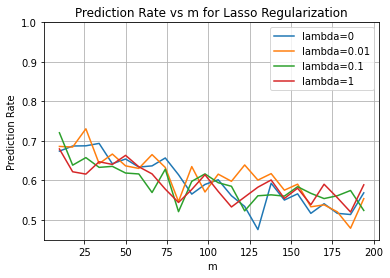

In [27]:
plt.plot(ms_0_l1, prediction_rate_0_l1, label="lambda=0")
plt.plot(ms_001_l1, prediction_rate_001_l1, label="lambda=0.01")
plt.plot(ms_01_l1, prediction_rate_01_l1, label="lambda=0.1")
plt.plot(ms_1_l1, prediction_rate_1_l1, label="lambda=1")
plt.ylim(0.45, 1)
plt.xlabel("m")
plt.ylabel("Prediction Rate")
plt.grid()
plt.title("Prediction Rate vs m for Lasso Regularization")
plt.legend();

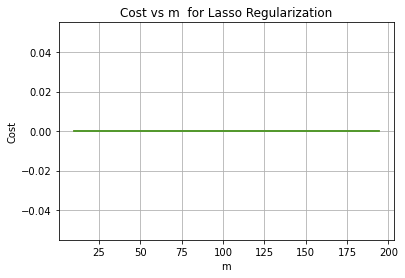

In [28]:
plt.plot(ms_001_l1, costs_001_l1)
plt.plot(ms_01_l1, costs_01_l1)
plt.plot(ms_1_l1, costs_1_l1)
plt.xlabel("m")
plt.ylabel("Cost")
plt.grid()
plt.title("Cost vs m  for Lasso Regularization");

As discussed above in Ridge regularization, we see that the model always converges, and we see that using Lasso Regularization doesn't play such a big role for any $m$, for the same reasons. This may not be the case in real data, where regularization is able to ignore these "extra" parameters which are only weakly correlated with the data.

```yaml
author: Dhruva Sambrani
roll-no: ms18163
```